## Topic Modelling on Reddit Data

In [4]:
# !pip install gensim

In [5]:
# conda install -c conda-forge pyldavis

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
import matplotlib

import gensim as gensim
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import re

import json

### Retrieve Data

In [7]:
reddit_df = pd.read_csv('reddit_singapore_mar.csv', encoding='UTF-8')

print(reddit_df.shape)
reddit_df

(380, 9)


,author,title,score,id,url,comms_num,created,body,timestamp
0,shian243,Singaporean student in London seeks eyewitness...,2936,fcn9km,https://www.straitstimes.com/singapore/singapo...,424,1583229539,NaN,3/3/2020 17:58
1,andylee69,Protection Level : Max,1959,fdrdib,https://i.redd.it/1jha4evfwsk41.jpg,89,1583419658,NaN,5/3/2020 22:47
2,satoshigekkouga2303,Singapore reports two deaths from Covid-19,1593,fm8vm4,https://www.straitstimes.com/singapore/singapo...,281,1584791447,NaN,21/3/2020 19:50
3,shian243,COVID-19: Singapore closes borders to all tour...,1594,fmt1xw,https://sg.news.yahoo.com/covid-19-singapore-c...,328,1584876271,NaN,22/3/2020 19:24
4,le_coder_boy,"Thank you, Grab driver :) (p.s. we didn't take...",1537,fbntfx,https://i.redd.it/o1yqc5at7zj41.jpg,33,1583060277,NaN,1/3/2020 18:57
...,...,...,...,...,...,...,...,...,...
375,discmon,"Supply from other countries in place, says Cha...",23,flp3do,https://www.straitstimes.com/singapore/supply-...,14,1584709027,NaN,20/3/2020 20:57
376,justmewayne,"Hong Kong, Singapore seen as safe harbours as ...",23,fl0eff,https://www.scmp.com/week-asia/health-environm...,28,1584606199,NaN,19/3/2020 16:23
377,MrSinkie,Supermarket shelves (photo taken 2 hours ago),22,fk4dvf,https://i.redd.it/4591or4388n41.jpg,14,1584476874,NaN,18/3/2020 4:27
378,etca2z,What kind of ActiveSG pyhsical distancing is t...,22,fk1mhy,https://i.redd.it/c2clal2bz6n41.jpg,8,1584461958,NaN,18/3/2020 0:19


In [8]:
# Get all posts(string) in a list

posts_list = reddit_df['title'].tolist()
        
print("Total number of posts: \n{} \n".format(len(posts_list)))
print("Sample posts: \n{}".format(posts_list[:3]))

Total number of posts: 
380 

Sample posts: 
['Singaporean student in London seeks eyewitnesses after coronavirus-related taunt and assault', 'Protection Level : Max', 'Singapore reports two deaths from Covid-19']


### Text Preprocessing, Tokenisation and Stop Words Removal

In [9]:
from nltk.tokenize import RegexpTokenizer
# splits string into substrings using a regular expression
# tokenises words that contain 1 or more (+) alphanumeric characters (\w) or '@'
retokenizer = RegexpTokenizer(r'[\w@]+')

# create stop words list
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# add context specific stop words
stop_words += ["rt", "got", "thats", "would", "going", "u", "get", 
                "also", "one", "could", "said", "like", "singapore",
                "coronavirus", "covid", "say"]

# create lemmatizer
wnl = nltk.stem.wordnet.WordNetLemmatizer()

# text pre-processing functions 
def remove_urls(s):
    # re.sub(pattern,repl,string) is used to replace substrings. Will replace the matches in string with repl
    return re.sub(r'https?://\S+', "", s)

def remove_usernames(s):
    return re.sub(r'@\S+', "", s)

def remove_specialchar(text, remove_digits=False):    
    if not remove_digits:
        pattern = r'[^a-zA-z0-9\s]'
    else:
        pattern = r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

In [10]:
def process_text(documents):
    processed_docs = []
    doc_tokens = []
    for doc in documents:
        doc = doc.lower()
        doc = remove_urls(doc)
        doc = remove_usernames(doc)
        doc = remove_specialchar(doc, remove_digits=True)
        doc_tokens = retokenizer.tokenize(doc)
        doc_tokens = [token for token in doc_tokens if token not in stop_words]
        doc_tokens = [wnl.lemmatize(token) for token in doc_tokens]    
#         doc = ' '.join(doc_tokens)
        processed_docs.append(doc_tokens)
#         print(doc_tokens)
    return processed_docs

In [11]:
processed_posts = process_text(posts_list)
print(len(processed_posts))
# print(processed_posts)

380


### Topic Modelling

#### Create dictionary representaion
`gensim` dictionary assigns an integer id to each unique word in the corpus

In [12]:
# Create a dictionary representation of the documents. Each word gets an id
dictionary = gensim.corpora.Dictionary(processed_posts)

print('Sample word to id mappings:\n', list(dictionary.items())[:75])
print('Total Vocabulary Size:', len(dictionary))

Sample word to id mappings:
 [(0, 'assault'), (1, 'coronavirusrelated'), (2, 'eyewitness'), (3, 'london'), (4, 'seek'), (5, 'singaporean'), (6, 'student'), (7, 'taunt'), (8, 'level'), (9, 'max'), (10, 'protection'), (11, 'death'), (12, 'report'), (13, 'two'), (14, 'border'), (15, 'close'), (16, 'shortterm'), (17, 'tourist'), (18, 'visitor'), (19, 'didnt'), (20, 'driver'), (21, 'grab'), (22, 'p'), (23, 'take'), (24, 'thank'), (25, 'buying'), (26, 'cat'), (27, 'even'), (28, 'panic'), (29, 'sense'), (30, 'access'), (31, 'attraction'), (32, 'free'), (33, 'shoot'), (34, 'took'), (35, 'went'), (36, 'hero'), (37, 'parent'), (38, 'case'), (39, 'imported'), (40, 'infection'), (41, 'new'), (42, 'reach'), (43, 'distancing'), (44, 'far'), (45, 'gone'), (46, 'social'), (47, 'full'), (48, 'kind'), (49, 'part'), (50, 'soul'), (51, 'time'), (52, 'ceo'), (53, 'excess'), (54, 'fairprice'), (55, 'item'), (56, 'policy'), (57, 'refund'), (58, 'say'), (59, 'standard'), (60, 'stockpiled'), (61, 'club'), (62,

#### Create the vector space model (bag of words model in gensim)
The function `doc2bow()` counts the number of occurrences of each unique word, converts the word to its integer word id and returns the result as a sparse vector (words from the dictionary not present in the document are not stored in the document vector)

In [13]:
# Transforming corpus into bag of words vectors
corpus_vect = [dictionary.doc2bow(text) for text in processed_posts]

In [14]:
# Check how the vector looks for the second news document

print(corpus_vect[2])
print("\n", )
print(processed_posts[2])

[(11, 1), (12, 1), (13, 1)]


['report', 'two', 'death']


In [15]:
print(type(corpus_vect))
print(len(corpus_vect))

<class 'list'>
380


In [16]:
# Viewing them as terms and their document frequencies, index into the dictionary

print([(dictionary[id] , freq) for id, freq in corpus_vect[1][:20]])

[('level', 1), ('max', 1), ('protection', 1)]


#### Build the LDA model

In [17]:
num_topics = 4

In [18]:
# Load previously generated LDA model from disk

ldamodel = pickle.load(open("reddit_topics", 'rb'))
for num ,topic in ldamodel.show_topics(formatted=True, num_topics=num_topics, num_words=10):
    print(str(num)+": "+ topic)

0: 0.045*"case" + 0.032*"new" + 0.011*"spore" + 0.011*"confirmed" + 0.011*"discharged" + 0.010*"safra" + 0.010*"infection" + 0.009*"measure" + 0.008*"cluster" + 0.008*"jurong"
1: 0.009*"malaysia" + 0.009*"country" + 0.008*"singaporean" + 0.006*"thailand" + 0.006*"cluster" + 0.005*"student" + 0.005*"travel" + 0.005*"singapore" + 0.005*"say" + 0.005*"spore"
2: 0.010*"malaysia" + 0.008*"food" + 0.008*"distancing" + 0.008*"pm" + 0.008*"mask" + 0.007*"panic" + 0.007*"lee" + 0.007*"social" + 0.006*"spore" + 0.006*"supply"
3: 0.007*"social" + 0.006*"stayhome" + 0.006*"home" + 0.006*"notice" + 0.006*"virus" + 0.005*"patient" + 0.005*"due" + 0.005*"situation" + 0.005*"distancing" + 0.005*"worker"


In [19]:
# Build LDA model

# ldamodel = gensim.models.ldamodel.LdaModel(corpus_vect, num_topics = num_topics, id2word=dictionary, passes=25)

In [20]:
# print(type(ldamodel))

In [21]:
# print(ldamodel.print_topics(num_topics = num_topics, num_words = 10))

In [22]:
# Show top 10 words for each topic
# Topic will be inferred from the words

for num ,topic in ldamodel.show_topics(formatted=True, num_topics=num_topics, num_words=10):
    print(str(num)+": "+ topic)

0: 0.045*"case" + 0.032*"new" + 0.011*"spore" + 0.011*"confirmed" + 0.011*"discharged" + 0.010*"safra" + 0.010*"infection" + 0.009*"measure" + 0.008*"cluster" + 0.008*"jurong"
1: 0.009*"malaysia" + 0.009*"country" + 0.008*"singaporean" + 0.006*"thailand" + 0.006*"cluster" + 0.005*"student" + 0.005*"travel" + 0.005*"singapore" + 0.005*"say" + 0.005*"spore"
2: 0.010*"malaysia" + 0.008*"food" + 0.008*"distancing" + 0.008*"pm" + 0.008*"mask" + 0.007*"panic" + 0.007*"lee" + 0.007*"social" + 0.006*"spore" + 0.006*"supply"
3: 0.007*"social" + 0.006*"stayhome" + 0.006*"home" + 0.006*"notice" + 0.006*"virus" + 0.005*"patient" + 0.005*"due" + 0.005*"situation" + 0.005*"distancing" + 0.005*"worker"


In [23]:
# To access and print topics from LDA model

topics = ldamodel.show_topics(formatted=True, num_topics=num_topics, num_words=10)
print(topics[3])

(3, '0.007*"social" + 0.006*"stayhome" + 0.006*"home" + 0.006*"notice" + 0.006*"virus" + 0.005*"patient" + 0.005*"due" + 0.005*"situation" + 0.005*"distancing" + 0.005*"worker"')


#### Compute Coherence Score

In [24]:
from gensim.models import CoherenceModel

# Compute Coherence Score for LDA Model
coherence_model_lda = CoherenceModel(model=ldamodel, texts=processed_posts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.540556047138091


#### Get Dominant Topic For Each Post

In [25]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=corpus_vect, texts=processed_posts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.9143,"case, new, spore, confirmed, discharged, safra...","[singaporean, student, london, seek, eyewitnes..."
1,1,3.0,0.8123,"social, stayhome, home, notice, virus, patient...","[protection, level, max]"
2,2,0.0,0.5097,"case, new, spore, confirmed, discharged, safra...","[report, two, death]"
3,3,2.0,0.8718,"malaysia, food, distancing, pm, mask, panic, l...","[close, border, tourist, shortterm, visitor]"
4,4,2.0,0.8897,"malaysia, food, distancing, pm, mask, panic, l...","[thank, grab, driver, p, didnt, take]"
5,5,2.0,0.9162,"malaysia, food, distancing, pm, mask, panic, l...","[even, cat, sense, panic, buying, cat, panic, ..."
6,6,2.0,0.8916,"malaysia, food, distancing, pm, mask, panic, l...","[free, access, attraction, went, took, shoot]"
7,7,1.0,0.7497,"malaysia, country, singaporean, thailand, clus...","[parent, hero]"
8,8,0.0,0.8749,"case, new, spore, confirmed, discharged, safra...","[case, reach, new, infection, imported]"
9,9,3.0,0.8463,"social, stayhome, home, notice, virus, patient...","[social, distancing, gone, far]"


In [34]:
# Add the topic labels

topic_label = {0.0: 'Local Cases',
              1.0: 'Global Impacts',
              2.0: 'Societal Impacts',
              3.0: 'Policy Measures'}

df_dominant_topic['Dominant_Topic_Label'] = df_dominant_topic['Dominant_Topic'].apply(lambda x: topic_label[x])
df_dominant_topic.head(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Dominant_Topic_Label
0,0,0.0,0.9143,"case, new, spore, confirmed, discharged, safra, infection, measure, cluster, jurong","[singaporean, student, london, seek, eyewitness, coronavirusrelated, taunt, assault]",Local Cases
1,1,3.0,0.8123,"social, stayhome, home, notice, virus, patient, due, situation, distancing, worker","[protection, level, max]",Policy Measures
2,2,0.0,0.5097,"case, new, spore, confirmed, discharged, safra, infection, measure, cluster, jurong","[report, two, death]",Local Cases
3,3,2.0,0.8718,"malaysia, food, distancing, pm, mask, panic, lee, social, spore, supply","[close, border, tourist, shortterm, visitor]",Societal Impacts
4,4,2.0,0.8897,"malaysia, food, distancing, pm, mask, panic, lee, social, spore, supply","[thank, grab, driver, p, didnt, take]",Societal Impacts


[Text(0, 0.5, 'Number of Reddit Posts'), Text(0.5, 0, 'Topics')]

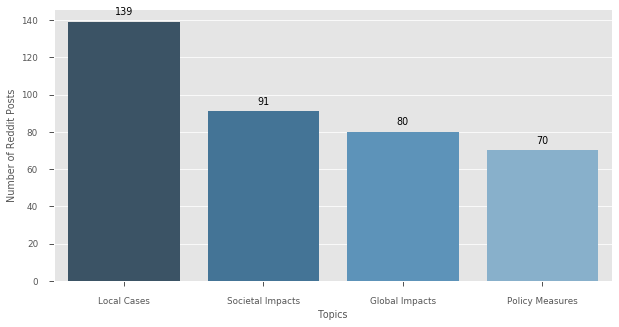

In [40]:
# Visualise contribution of each topics to Reddit Posts on COVID-19

#### Plot settings ####
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')
matplotlib.rcParams['font.family'] = "DejaVu Sans"
plt.rcParams['figure.figsize'] = [10, 5]
sns.set_context('paper')
####


# Plot chart
ax = sns.countplot(x="Dominant_Topic_Label",
                    data=df_dominant_topic,
                    order = df_dominant_topic['Dominant_Topic_Label'].value_counts().index,
                    palette=("Blues_d"))


# Add value labels
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

    
# Change width of bars
# def change_width(ax, new_value) :
#     for patch in ax.patches :
#         current_width = patch.get_width()
#         diff = current_width - new_value

#         # we change the bar width
#         patch.set_width(new_value)

#         # we recenter the bar
#         patch.set_x(patch.get_x() + diff * .5)
# change_width(ax, .60)


# Add axis labels
ax.set(xlabel='Topics', ylabel='Number of Reddit Posts')


# plt.savefig('reddit_topic_contribution.png', dpi=400, transparent=True, bbox_inches="tight")

#### Get The Most Representative Sentence Of Each Topic

In [28]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9683,"case, new, spore, confirmed, discharged, safra, infection, measure, cluster, jurong","[honest, question, far, locking, gonna, effective, barrier, lowering, case, considering, fact, c..."
1,1.0,0.9649,"malaysia, country, singaporean, thailand, cluster, student, travel, singapore, say, spore","[dont, advocate, school, closure, way, measure, taken, school, tackle, situation, questionable, ..."
2,2.0,0.9555,"malaysia, food, distancing, pm, mask, panic, lee, social, spore, supply","[guy, casually, wear, gas, mask, buy, mala, xiang, guo, redhill, food, centre, becomes, subject,..."
3,3.0,0.9555,"social, stayhome, home, notice, virus, patient, due, situation, distancing, worker","[patient, meal, medicine, delivered, robot, whats, second, robot, deployed, clean, chat, patient..."


In [30]:
# Retrieve the representative tweet for topic 0 -- Local Cases

topic0_reptext = sent_topics_sorteddf['Representative Text'][0]
topic0_index = processed_posts.index(topic0_reptext)

topic0_reppost = reddit_df.iloc[topic0_index]
topic0_reppost

author                                                                                                  nlim2004
title        Honest question: How far is locking down Singapore gonna be an effective barrier for lowering co...
score                                                                                                         51
id                                                                                                        fm9gq5
url          https://www.reddit.com/r/singapore/comments/fm9gq5/honest_question_how_far_is_locking_down_singa...
comms_num                                                                                                     83
created                                                                                               1584794254
body         Really curious. Please share your opinions.\n\nAs the title suggests, wouldn't lockdown be detri...
timestamp                                                                                       

In [ ]:
# Retrieve the representative tweet for topic 1 -- Global Cases

topic1_reptext = sent_topics_sorteddf['Representative Text'][1]
topic1_index = processed_posts.index(topic1_reptext)

topic1_reppost = reddit_df.iloc[topic1_index]
topic1_reppost

In [32]:
# Retrieve the representative tweet for topic 2 -- Societal Impacts

topic2_reptext = sent_topics_sorteddf['Representative Text'][2]
topic2_index = processed_posts.index(topic2_reptext)

topic2_reppost = reddit_df.iloc[topic2_index]
topic2_reppost

author                                                                                            Spectacle-Phua
title        Guy casually wears gas mask to buy mala xiang guo at Redhill Food Centre, becomes subject of unc...
score                                                                                                         29
id                                                                                                        ffsc2t
url                                                           https://mothership.sg/2020/03/gas-mask-redhill-85/
comms_num                                                                                                     12
created                                                                                               1583776457
body                                                                                                         NaN
timestamp                                                                                       

In [33]:
# Retrieve the representative tweet for topic 3 -- Policy Measures

topic3_reptext = sent_topics_sorteddf['Representative Text'][3]
topic3_index = processed_posts.index(topic3_reptext)

topic3_reppost = reddit_df.iloc[topic3_index]
topic3_reppost

author                                                                                                 PeekaB00_
title        Singapore coronavirus patients to have their meals, medicine delivered by robot. What's more, a ...
score                                                                                                         37
id                                                                                                        feche3
url          https://thethaiger.com/hot-news/coronavirus/singapore-coronavirus-patients-to-have-their-meals-m...
comms_num                                                                                                     17
created                                                                                               1583524849
body                                                                                                         NaN
timestamp                                                                                       

#### Visualise topics

In [64]:
import pyLDAvis.gensim

In [216]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim.prepare(ldamodel, corpus_vect, dictionary)

C:\Users\Xiao Rong\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [218]:
# Show visualisation
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.145484  0.022112       1        1  35.630669
2     -0.076584  0.103172       2        1  24.130596
1     -0.048247 -0.075989       3        1  22.003180
3     -0.020653 -0.049296       4        1  18.235550, topic_info=    Category       Freq         Term      Total  loglift  logprob
38   Default  51.000000         case  51.000000  30.0000  30.0000
41   Default  35.000000          new  35.000000  29.0000  29.0000
324  Default  12.000000    confirmed  12.000000  28.0000  28.0000
325  Default  12.000000   discharged  12.000000  27.0000  27.0000
40   Default  10.000000    infection  10.000000  26.0000  26.0000
..       ...        ...          ...        ...      ...      ...
5     Topic4   2.604950  singaporean  13.966497   0.0225  -5.3391
417   Topic4   2.000712       school   7.291593   0.4086  -5.6030
144   Topic4   2.482581      cluster  16.384886  -0.1853  -5.3872
38    Topic4   2.565465         case  51.048542  -1.2888  -5.3544
58    Topic4   1.992526          say  13.492342  -0.2109  -5.6071

[248 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
180       2  0.501667       act
779       1  0.840568   airline
1420      3  0.762050  alleging
143       4  0.528305   another
746       1  0.931210    anyone
...     ...       ...       ...
134       4  0.278211    worker
100       1  0.247961     world
100       2  0.495922     world
100       3  0.247961     world
390       1  0.703583   yearold

[329 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4])

In [217]:
# Save visualisation to html page
# pyLDAvis.save_html(p, 'reddit_lda.html')

#### Finalize Model

In [2]:
import pickle

In [66]:
#save model to disk
# pickle.dump(ldamodel, open("reddit_topics", "wb"))

In [21]:
#load model from disk
ldamodel = pickle.load(open("reddit_topics", 'rb'))
for num ,topic in ldamodel.show_topics(formatted=True, num_topics=num_topics, num_words=10):
    print(str(num)+": "+ topic)

0: 0.045*"case" + 0.032*"new" + 0.011*"spore" + 0.011*"confirmed" + 0.011*"discharged" + 0.010*"safra" + 0.010*"infection" + 0.009*"measure" + 0.008*"cluster" + 0.008*"jurong"
1: 0.009*"malaysia" + 0.009*"country" + 0.008*"singaporean" + 0.006*"thailand" + 0.006*"cluster" + 0.005*"student" + 0.005*"travel" + 0.005*"singapore" + 0.005*"say" + 0.005*"spore"
2: 0.010*"malaysia" + 0.008*"food" + 0.008*"distancing" + 0.008*"pm" + 0.008*"mask" + 0.007*"panic" + 0.007*"lee" + 0.007*"social" + 0.006*"spore" + 0.006*"supply"
3: 0.007*"social" + 0.006*"stayhome" + 0.006*"home" + 0.006*"notice" + 0.006*"virus" + 0.005*"patient" + 0.005*"due" + 0.005*"situation" + 0.005*"distancing" + 0.005*"worker"


### Save & Restore Notebook Session

In [ ]:
# !pip install dill

In [36]:
import dill

In [41]:
#save notebook session
dill.dump_session('reddit_lda.db')

In [ ]:
#restore notebook session
dill.load_session('reddit_lda.db')